In [1]:
from mxnet import autograd
from mxnet import gluon
from mxnet import image
from mxnet import init
from mxnet import nd
from mxnet.gluon.model_zoo import vision as model
from mxnet.gluon import nn
from mxnet.gluon.data import vision
import numpy as np
import mxnet as mx
import sys
sys.path.insert(0, '../../utils')
from dataset import *
from netlib import *
import os
import shutil
from cifar10_utils import show_images, parse_log, show_log, update
import matplotlib.pyplot as plt
%matplotlib inline

logs = ["train8_resnet18_r1_i10_lr01_bF", "train8_resnet18_r1_i10_lr01_bT", 'resnet18_me_200e',
        'train8_resnet18_r1_i10_lr01_bT_prob',
        'train8_resnet18_r1_i10_lr01_bT_finetune_prob', 'train8_resnet18_r1_i10_lr01_bF_finetune_prob',
        'train8_resnet18_r1_i10_lr01_bT_finetune', 'train8_resnet18_r1_i10_lr01_bF_finetune',
        'train8_resnet18_me_200e_bT_finetune', 'train8_resnet18_me_200e_bT_finetune_prob',
       'resnet18_me_backgrad_prob_online_iter10_lr01_softlabel01']

In [10]:
def parse_logs(logs):
    dataset = {}
    for log_file in logs:
        dataset[log_file] = parse_log('../../log/' + log_file + '.log')
    return dataset

def show_log(datasets, log, key, as_epoch=True, x_range=(0, -1), idx=None):
    data = datasets[log][key]
    if idx is not None:
        data = np.array(data)[:, idx]
    plt.plot(datasets[log]['epoch'][x_range[0]:x_range[1]], data[x_range[0]:x_range[1]], label=log)
    
def show_logs(logs, key, as_epoch=True, x_range=(0, -1), idx=None, datasets=None):
    if datasets is None: datasets = parse_logs(logs)
    for log in logs:
        if datasets[log].has_key(key):
            show_log(datasets, log, key, as_epoch, x_range, idx)
    plt.legend()
    
def show_logs_multi_key(logs, keys, as_epochs=True, x_ranges=(0, -1), idxs=None, MN=None, datasets=None):
    import matplotlib as mpl
    mpl.rcParams['figure.dpi'] = 120
    plt.figure(figsize=(12, 4))
    
    if datasets is None: datasets = parse_logs(logs)
    
    length = len(keys)
    as_epochs = as_epochs if isinstance(as_epochs, list) else [as_epochs] * length
    x_ranges = x_ranges if isinstance(x_ranges, list) else [x_ranges] * length
    idxs = idxs if isinstance(idxs, list) else [idxs] * length
    if MN == None:
        MN = (1, length)
    MN = str(MN[0]) + str(MN[1])
    for i, (key, as_epoch, x_range, idx) in enumerate(zip(keys, as_epochs, x_ranges, idxs)):
        plt.subplot(int(MN + str(i+1)))
        plt.title(key)
        show_logs(logs, key, as_epoch, x_range, idx, datasets)
    
def half_data(log, keys):
    for key in keys:
        d = datasets[log][key]
        datasets[log][key] = d[1:len(d):2]
    datasets[log]['epoch'] = range(len(datasets[log]['epoch']))

def rename(logs, keys, new_keys):
    for log in logs:
        for k1, k2 in zip(keys, new_keys):
            datasets[log][k2] = datasets[log][k1]
            del datasets[log][k1]
            
def to_float_list(logs, keys):
    for log in logs:
        for k in keys:
            datasets[log][k] = [(float(a), 0, 0, 0) for a in datasets[log][k]]
def to_float(logs, keys):
    for log in logs:
        for k in keys:
            datasets[log][k] = [float(a) for a in datasets[log][k]]
    
datasets = parse_logs(logs)
half_data(logs[2], ['epoch', 'train_acc', 'valid_acc', 'loss'])
to_float_list(logs[3:5]+[logs[9]], ['bloss'])
to_float(logs[3:5]+[logs[9]], ['epoch'])
half_data(logs[10], ['epoch', 'train_acc', 'valid_acc', 'loss'])

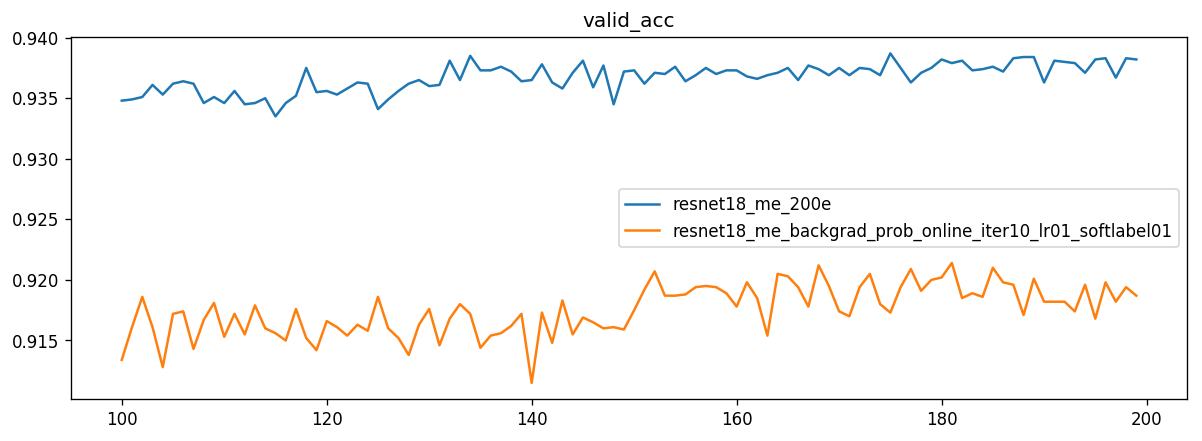

In [13]:
# baseline and online_softlabel
show_logs_multi_key(['resnet18_me_200e', 'resnet18_me_backgrad_prob_online_iter10_lr01_softlabel01'], ['valid_acc'], x_ranges=(100, 200))

# 2. questions

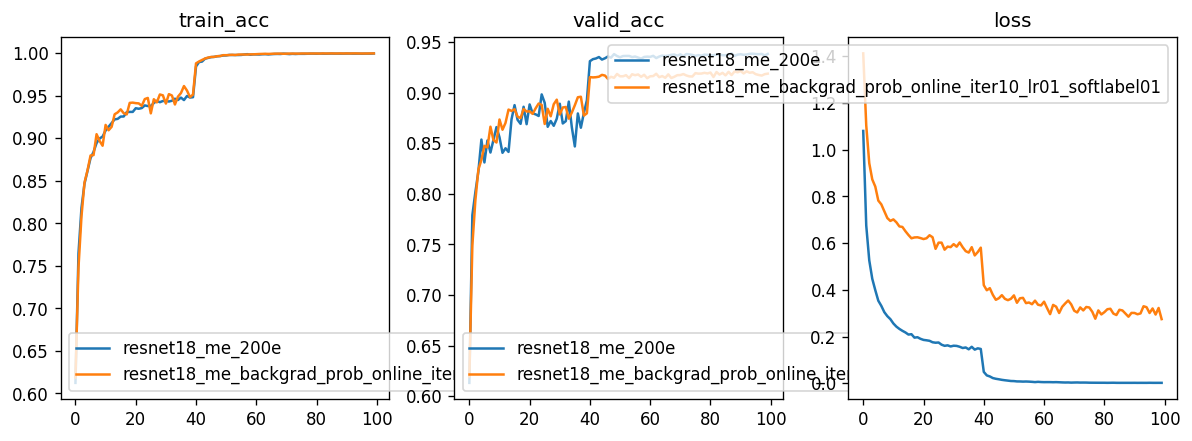

In [11]:
# baseline and online_softlabel
show_logs_multi_key(['resnet18_me_200e', logs[10]], ['train_acc', 'valid_acc', 'loss'], x_ranges=(0, 100))

## 2.1 why batch mean_std inference so much, why prob way have no inference?
```
valid acc is diff too much, but other standard is almost same.
batch mean std = True/False means:
True: generate data BN use batch mean/std, and test BN use moving mean/std
False: both generate data BN and test BN use moving mean/std

if not finetune, moving mean same as batch mean at start, but after some epoch, moving mean become global mean.

and if use prob trained way, it will have no inference
```
## 2.2 why train acc/valid acc /loss will go wrose when second lr decay happened?
```
very small lr learning, will cause valid acc down
```
## 2.3 why bloss keep bigger while train, but down after sencond lr decay?
compare to finetune exp and prob way

### more
```
1. batch mean/std and global mean/std
2. epoch base train learn and batch base train learn
    bloss up and low
    valid acc / train acc / loss wrose.
``` 

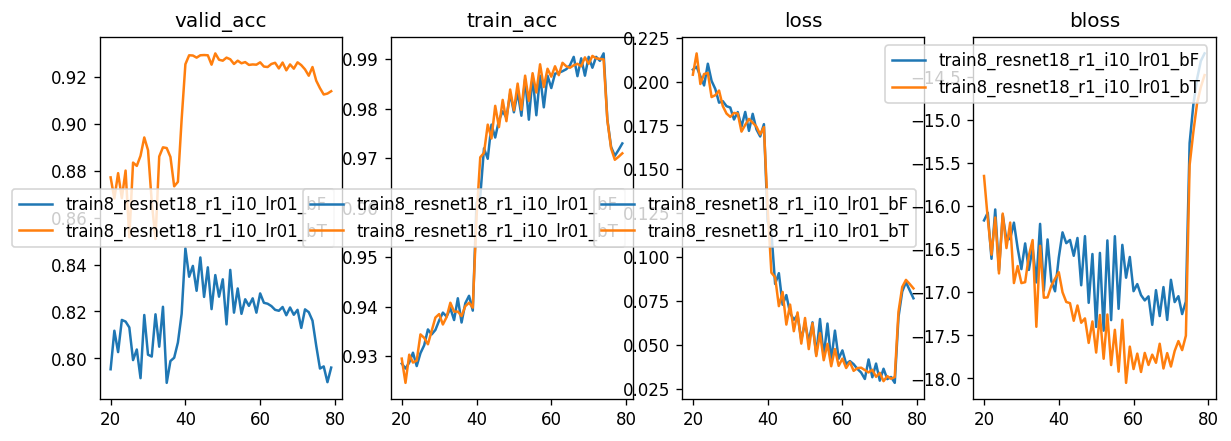

In [4]:
show_logs_multi_key(logs[0:2], ['valid_acc', 'train_acc', 'loss', 'bloss'], x_ranges=(20, 80), idxs=[None, None, None, 0])

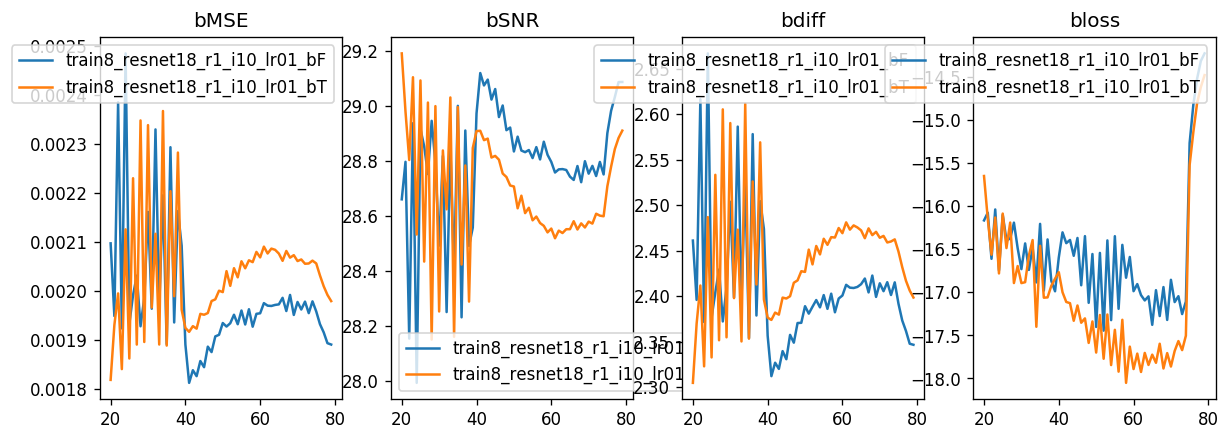

In [7]:
show_logs_multi_key(logs[0:2], ['bMSE', 'bSNR', 'bdiff', 'bloss'], x_ranges=(20, 80), idxs=[0, 0, 0, 0])

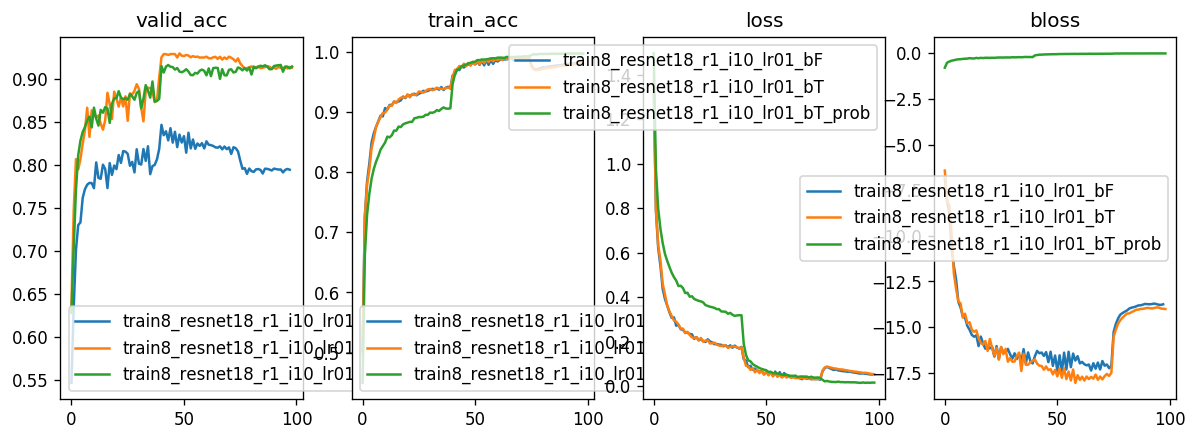

In [11]:
show_logs_multi_key(logs[:2]+[logs[3]], ['valid_acc', 'train_acc', 'loss', 'bloss'], x_ranges=(0, -1), idxs=[None, None, None, 0])

### 2.1.1 batch mean std inference also exist while train net use finetune way, but in prob way almost no infrence

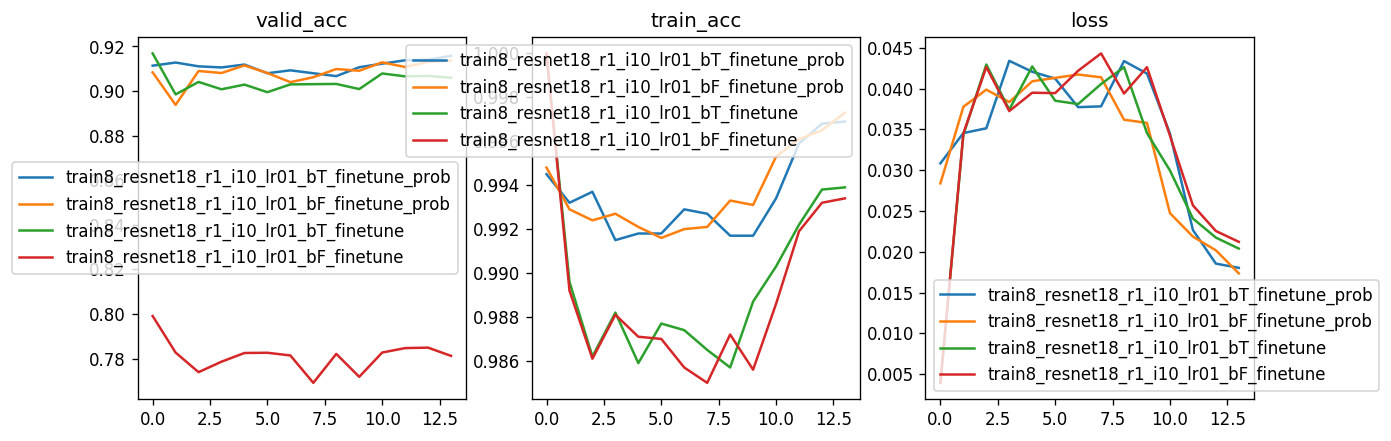

In [55]:
# finetune resnet18_me_backgrad_prob_online_iter10_lr01
show_logs_multi_key(logs[4:8], ['valid_acc', 'train_acc', 'loss'], x_ranges=(0, -1))

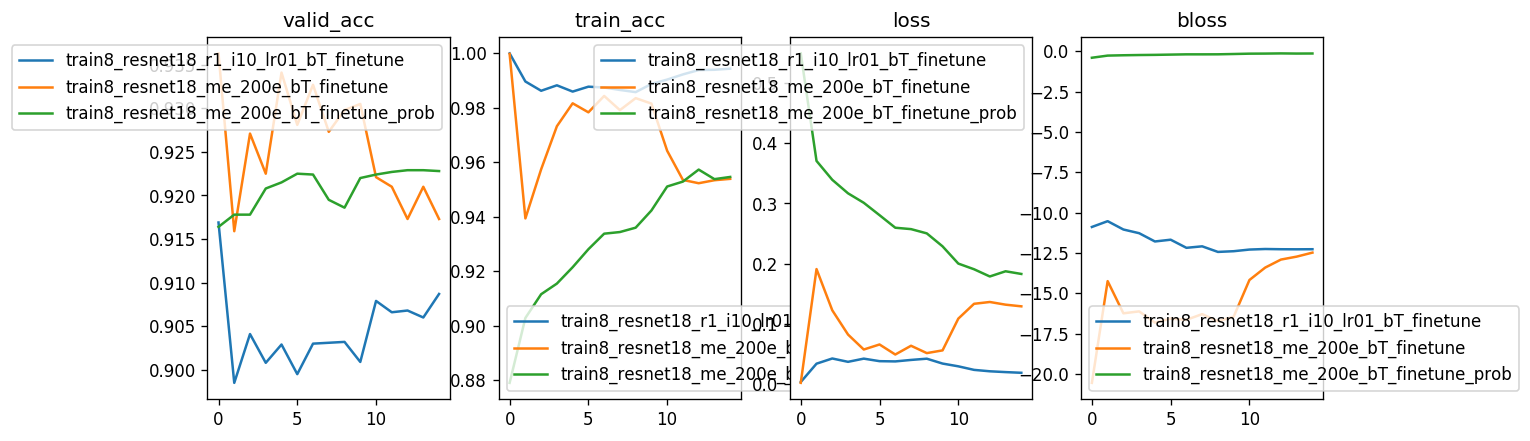

In [22]:
ids = [logs[6], logs[8], logs[9]]
show_logs_multi_key(ids, ['valid_acc', 'train_acc', 'loss', 'bloss'], x_ranges=(0, 15), idxs=[None, None, None, 0])